# <a id='toc1_'></a>[Visual Question Answering](#toc0_)

Visual Question Answering (VQA) is the task of answering open-ended questions based on an image. VQA has many applications: Medical VQA, Education purposes, for surveillance and numerous other applications. In this project we will use [VizWiz](https://vizwiz.org/tasks-and-datasets/vqa/) dataset for Visual Question Answering, this dataset was constructed to train models to help visually impaired people.  In the words of creators of VizWiz: “we introduce the visual question answering (VQA) dataset coming from this population, which we call VizWiz-VQA.  It originates from a natural visual question answering setting where blind people each took an image and recorded a spoken question about it, together with 10 crowdsourced answers per visual question.”



<p align="center">
  <img src="Latex Paper\graphics\chapter1\vizwiz_example.png" alt="vizwiz_example" width="500"/>
</p>

- **Note:** This repository is an implementation for [Less is More: Linear Layers on CLIP Features as Powerful VizWiz Model](https://arxiv.org/abs/2206.05281) paper.
- It is really advised to read OpenAI's [CLIP](https://openai.com/blog/clip/) paper before reading this repository if you have enough time.

## <a id='toc1_1_'></a>[Installing Required Libraries](#toc0_)

In [12]:
# Importing os, numpy and pandas for data manipulation
import os
import numpy as np 
import pandas as pd

# For data visualization, we will use matplotlib, wordcloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# For data preprocessing, we will use Counter, train_test_split, Levenshtein distance, Python Image Library and OneHotEncoder
from collections import Counter
import Levenshtein as lev
from PIL import Image
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# For saving and loading the preprocessed data, we will use pickle
import pickle

# For Building the model, we will use PyTorch and its functions
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import clip
from torch.utils.data import Dataset, DataLoader

# For taking the image from the URL, we will use requests
import requests

# For evaluation, we will need sklearn.metrics.average_precision_score
from sklearn.metrics import average_precision_score

# Importing json for results formatting which will be uploaded for evaluation
import json

## <a id='toc1_3_'></a>[Configuring the Notebook](#toc0_)

In [26]:
# Configuring the paths for the dataset
INPUT_PATH = 'E:\HK1  2025-2026\Đồ án CS420\VQA\Dataset\VizWiz-'
ANNOTATIONS = INPUT_PATH + '/Annotations'
TRAIN_PATH = INPUT_PATH + '/train/train'
VALIDATION_PATH = INPUT_PATH + '/val/val'
ANNOTATIONS_TRAIN_PATH = ANNOTATIONS + '/train.json'
ANNOTATIONS_VAL_PATH = ANNOTATIONS + '/val.json'
ANNOTATIONS_TEST_PATH = ANNOTATIONS + '/test.json'
TEST_PATH = INPUT_PATH + '/test/test'

OUTPUT_PATH = 'E:\HK1  2025-2026\Đồ án CS420\VQA\Output'
ANSWER_SPACE = 0 # Will be configured later when we build the vocab using the methodology described in the paper
MODEL_NAME = "ViT-L/14@336px" # This is the backbone of the CLIP model


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# Using accelerated computing if available
print("CUDA available:", torch.cuda.is_available())
print("Device:", torch.device("cuda" if torch.cuda.is_available() else "cpu"))
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))

CUDA available: True
Device: cuda
GPU Name: NVIDIA GeForce RTX 3060


## <a id='toc1_4_'></a>[Processing Data](#toc0_)

In [3]:
import json
import pandas as pd

# đọc JSON
with open(ANNOTATIONS_TRAIN_PATH, 'r') as f:
    data = json.load(f)

df = pd.DataFrame(data)

print(df.head())


                       image  \
0  VizWiz_train_00000000.jpg   
1  VizWiz_train_00000001.jpg   
2  VizWiz_train_00000002.jpg   
3  VizWiz_train_00000003.jpg   
4  VizWiz_train_00000004.jpg   

                                            question  \
0                   What's the name of this product?   
1        Can you tell me what is in this can please?   
2  Is this enchilada sauce or is this tomatoes?  ...   
3            What is the captcha on this screenshot?   
4                                 What is this item?   

                                             answers answer_type  answerable  
0  [{'answer_confidence': 'yes', 'answer': 'basil...       other           1  
1  [{'answer_confidence': 'yes', 'answer': 'soda'...       other           1  
2  [{'answer_confidence': 'yes', 'answer': 'these...       other           1  
3  [{'answer_confidence': 'yes', 'answer': 't36m'...       other           1  
4  [{'answer_confidence': 'yes', 'answer': 'solar...       other           

In [4]:
df.dtypes

image          object
question       object
answers        object
answer_type    object
answerable      int64
dtype: object

In [6]:
print(df)

                           image  \
0      VizWiz_train_00000000.jpg   
1      VizWiz_train_00000001.jpg   
2      VizWiz_train_00000002.jpg   
3      VizWiz_train_00000003.jpg   
4      VizWiz_train_00000004.jpg   
...                          ...   
20518  VizWiz_train_00023949.jpg   
20519  VizWiz_train_00023950.jpg   
20520  VizWiz_train_00023951.jpg   
20521  VizWiz_train_00023952.jpg   
20522  VizWiz_train_00023953.jpg   

                                                question  \
0                       What's the name of this product?   
1            Can you tell me what is in this can please?   
2      Is this enchilada sauce or is this tomatoes?  ...   
3                What is the captcha on this screenshot?   
4                                     What is this item?   
...                                                  ...   
20518                  What's the color for this laptop?   
20519  (inaudible) can you see it? If so, then tell m...   
20520         What are the 

In [16]:
def read_dataframe(path):
    """
    Reads the JSON file and returns a dataframe with available columns
    (image, question, answers, answer_type, answerable if exist)

    Parameters:
        path (str): Path to the JSON file

    Returns:
        df (pandas.DataFrame): Dataframe with the available columns
    """
    df = pd.read_json(path)

    cols = ['image', 'question', 'answers', 'answer_type', 'answerable']

    existing_cols = [c for c in cols if c in df.columns]
    df = df[existing_cols]

    return df

def split_train_test(dataframe, test_size = 0.05):
    """
    Splits the dataframe into train and test sets

    Parameters:
        dataframe (pandas.DataFrame): Dataframe to be split

    Returns:
        train (pandas.DataFrame): Train set
        test (pandas.DataFrame): Test set
    """
    train, test = train_test_split(dataframe, test_size=test_size, random_state=42, stratify=dataframe[['answer_type', 'answerable']])
    return train, test

def plot_histogram(dataframe, column):
    """
    Plots the histogram of the given column

    Parameters:
        dataframe (pandas.DataFrame): Dataframe to be plotted
        column (str): Column to be plotted
    
    Returns:
        None
    """
    plt.hist(dataframe[column])
    plt.title(column)
    plt.show()

def plot_pie(dataframe, column):
    """
    Plots the pie chart of the given column

    Parameters:
        dataframe (pandas.DataFrame): Dataframe to be plotted
        column (str): Column to be plotted
    
    Returns:
        None
    """
    value_counts = dataframe[column].value_counts()
    plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%')
    plt.title(column)
    plt.show()

def plot_wordcloud(dataframe, column):
    """
    Plots the wordcloud of the given column

    Parameters:
        dataframe (pandas.DataFrame): Dataframe to be plotted
        column (str): Column to be plotted

    Returns:
        None
    """
    text = " ".join([word for word in dataframe[column]])

    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    min_font_size = 10).generate(text) 
    
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()

def explore_dataframe(dataframe):
    """
    Explores the dataframe (EDA) by plotting the pie charts, histograms and wordclouds of the columns

    Parameters:
        dataframe (pandas.DataFrame): Dataframe to be explored

    Returns:
        None
    """
    plot_pie(dataframe, 'answer_type')
    plot_pie(dataframe, 'answerable')
    plot_histogram(dataframe, 'answerable')
    plot_wordcloud(dataframe, 'question')
    
def get_number_of_distinct_answers(dataframe):
    """
    Returns the number of distinct answers in the dataframe

    Parameters:
        dataframe (pandas.DataFrame): Dataframe to be explored

    Returns:
        len(unique_answers_set) (int): Number of distinct answers in the dataframe
    """
    unique_answers_set = set()
    for row in dataframe['answers']:
        for answer_map in row:
            unique_answers_set.add(answer_map['answer'])
    return len(unique_answers_set)

def process_images(dataframe, image_path, clip_model, preprocessor, device):
    """
    Processes the images in the dataframe and returns the image features

    Parameters:
        dataframe (pandas.DataFrame): Dataframe containing the images
        image_path (str): Path to the input images
        clip_model (clip.model.CLIP): CLIP model
        preprocessor (clip.model.Preprocess): Preprocessor for the CLIP model
        device (torch.device): Device to be used for processing
    
    Returns:
        images (list): List of image features
    """
    images = []
    for _, row in dataframe.iterrows():
        full_path = image_path + "/" + row['image']
        image = Image.open(full_path)
        image = preprocessor(image).unsqueeze(0).to(device)
        image_features = clip_model.encode_image(image)
        image_features = torch.flatten(image_features, start_dim=1)
        images.append(image_features)
    return images

def process_questions(dataframe, clip_model,device):
    """
    Processes the questions in the dataframe and returns the question features

    Parameters:
        dataframe (pandas.DataFrame): Dataframe containing the questions
        clip_model (clip.model.CLIP): CLIP model
        device (torch.device): Device to be used for processing

    Returns:
        questions (list): List of question features
    """
    questions = []
    for _, row in dataframe.iterrows():
        question = row['question']
        question =  clip.tokenize(question).to(device)
        text_features = clip_model.encode_text(question).float()
        text_features = torch.flatten(text_features, start_dim=1)
        questions.append(text_features)
    return questions

## <a id='toc1_5_'></a>[Creating Dataframes & Splitting](#toc0_)

Ussing the defined function to create dataframes and split them into train and test cases.

In [17]:
train_df = read_dataframe(ANNOTATIONS_TRAIN_PATH)
validation_df = read_dataframe(ANNOTATIONS_VAL_PATH)
test_df = read_dataframe(ANNOTATIONS_TEST_PATH)
ANSWER_SPACE = get_number_of_distinct_answers(train_df) # The answer space will be decreased later when we process the answers
print("Number of distinct answers: ", ANSWER_SPACE)



Number of distinct answers:  41226


## <a id='toc1_6_'></a>[Exploratory Data Analysis](#toc0_)

### <a id='toc1_6_1_'></a>[Training Dataframe](#toc0_)

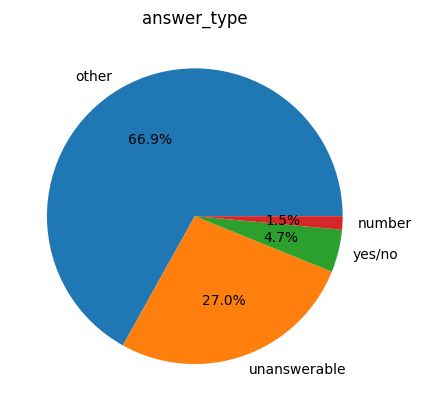

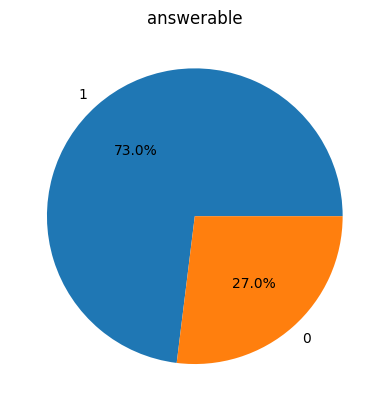

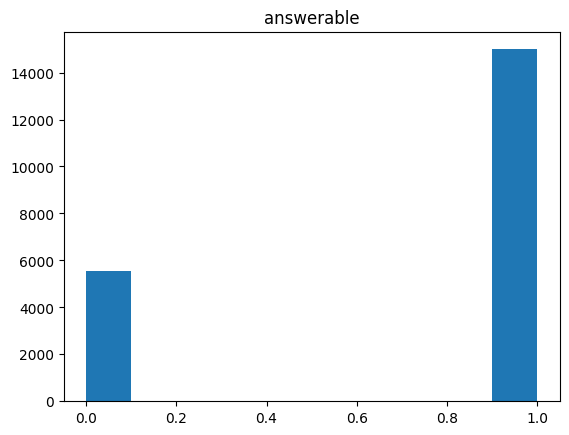

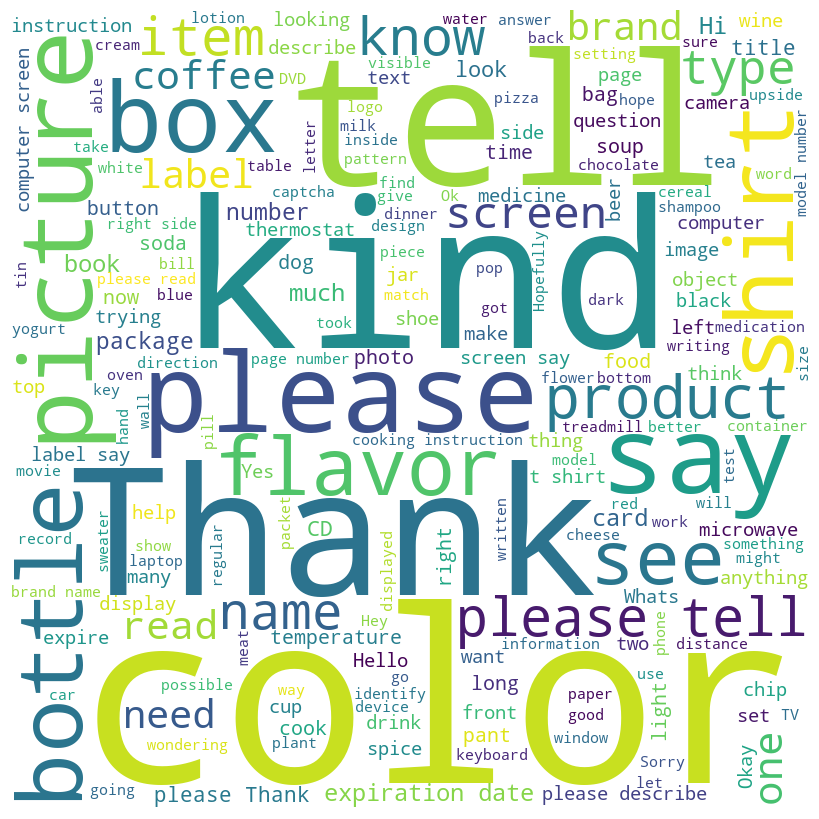

Number of distinct answers:  41226
Number of samples in train:  20523


In [18]:
explore_dataframe(train_df)
print("Number of distinct answers: ", get_number_of_distinct_answers(train_df))
print("Number of samples in train: ", len(train_df))

### <a id='toc1_6_2_'></a>[Validation Dataframe](#toc0_)

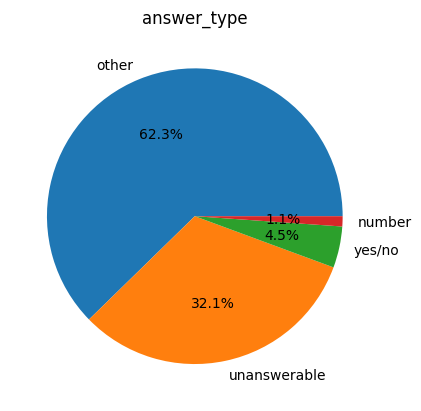

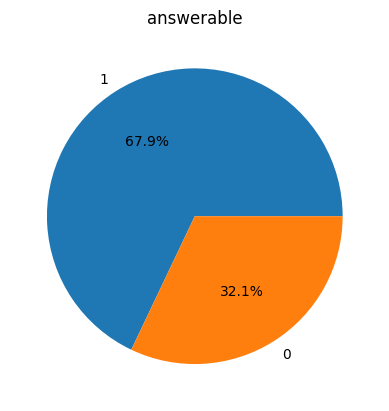

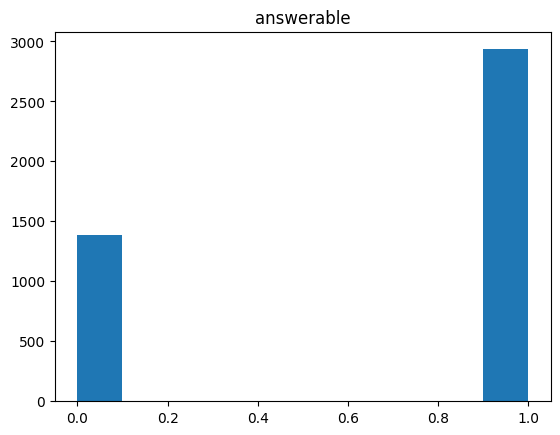

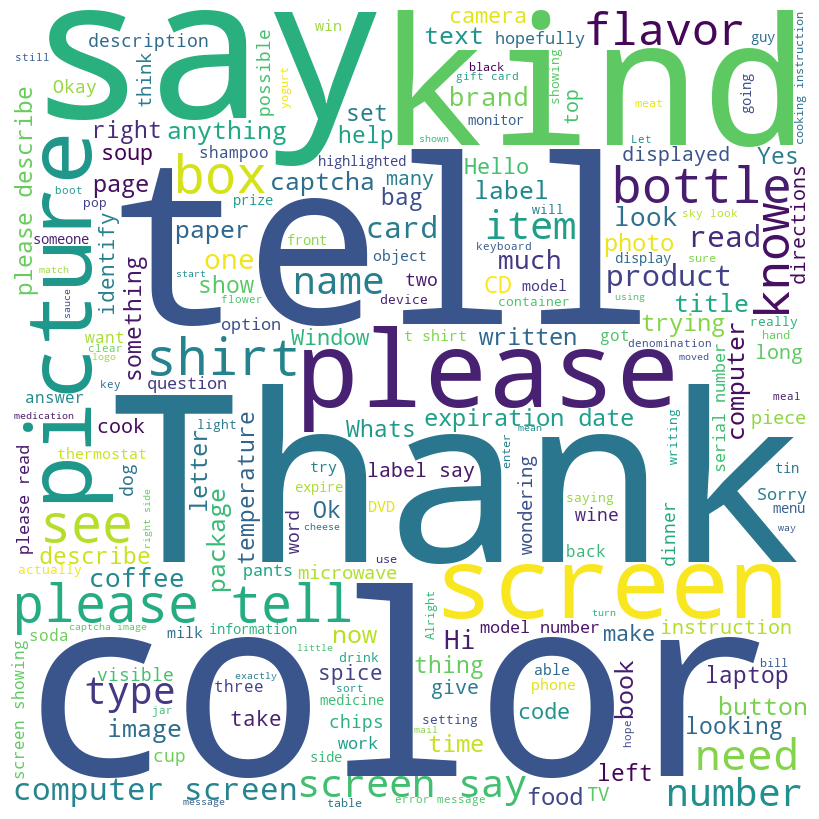

Number of distinct answers:  10903
Number of samples in validation set:  4319


In [19]:
explore_dataframe(validation_df)
print("Number of distinct answers: ", get_number_of_distinct_answers(validation_df))
print("Number of samples in validation set: ", len(validation_df))

### <a id='toc1_6_3_'></a>[Testing Dataframe](#toc0_)

In [22]:
def eda_test_df(df):
    print("Shape:", df.shape)
    print("Columns:", df.columns.tolist())
    print("\nMissing values:\n", df.isnull().sum())
    
    print("\nQuestion length stats:")
    df['question_length'] = df['question'].apply(lambda x: len(str(x)))
    df['question_word_count'] = df['question'].apply(lambda x: len(str(x).split()))
    print(df[['question_length','question_word_count']].describe())
    
    print("\nUnique images:", df['image'].nunique())
    print("\nSample questions:")
    for q in df['question'].sample(5, random_state=42).values:
        print("-", q)

eda_test_df(test_df)


Shape: (8000, 2)
Columns: ['image', 'question']

Missing values:
 image       0
question    0
dtype: int64

Question length stats:
       question_length  question_word_count
count      8000.000000          8000.000000
mean         31.695250             6.559250
std          25.896905             5.179874
min           6.000000             2.000000
25%          18.000000             4.000000
50%          24.000000             5.000000
75%          36.000000             7.000000
max         266.000000            57.000000

Unique images: 8000

Sample questions:
- Can you tell what is written on this T-shirt?
- Do you think this shirt would go with these jeans, and if you could confirm the color of the shirt, please?
- What is that on the package?
- What is this pattern?
- What button am I supposed to push?


## <a id='toc1_7_'></a>[Processing Images & Questions using CLIP model](#toc0_)

Instead of lazy processing of images and questions embeddings and recomputing them over and over during forward passes in the model, we can preprocess them and save them in a file using Pickle. This will save us a lot of time when we want to train our model and decrease the time taken by one epoch drastically.

In [27]:
clip_model, preprocessor = clip.load(MODEL_NAME, device = DEVICE)
clip_model.eval().requires_grad_(False)

training_images = process_images(train_df, TRAIN_PATH, clip_model, preprocessor, DEVICE)
training_questions = process_questions(train_df, clip_model, DEVICE)
with open(OUTPUT_PATH + 'training_images.pkl', 'wb') as f:
    pickle.dump(training_images, f)
with open(OUTPUT_PATH + 'training_questions.pkl', 'wb') as f:
    pickle.dump(training_questions, f)

validation_images = process_images(validation_df, VALIDATION_PATH, clip_model, preprocessor, DEVICE)
validation_questions = process_questions(validation_df, clip_model, DEVICE)
with open(OUTPUT_PATH + 'validation_images.pkl', 'wb') as f:
    pickle.dump(validation_images, f)
with open(OUTPUT_PATH + 'validation_questions.pkl', 'wb') as f:
    pickle.dump(validation_questions, f)

test_images = process_images(test_df, TEST_PATH, clip_model, preprocessor, DEVICE)
test_questions = process_questions(test_df, clip_model, DEVICE)
with open(OUTPUT_PATH + 'test_images.pkl', 'wb') as f:  
    pickle.dump(test_images, f)
with open(OUTPUT_PATH + 'test_questions.pkl', 'wb') as f:
    pickle.dump(test_questions, f)

## <a id='toc1_8_'></a>[Creating Dataset Class](#toc0_)

In [28]:
import torch
from torch.utils.data import Dataset
import numpy as np
from collections import Counter
from sklearn.preprocessing import OneHotEncoder
import Levenshtein as lev

class VizWizDataset(Dataset):
    def __init__(self, dataframe, 
                 answer_type_onehotencoder=None, 
                 answer_onehotencoder=None, 
                 model_name="RN50x64", 
                 images_features=torch.tensor([]), 
                 questions_features=torch.tensor([])):
        super(VizWizDataset, self).__init__()

        # Counter tổng số lần xuất hiện của tất cả answers (dùng để tie-breaking)
        self.answer_counter = Counter() 

        # Lưu embeddings ảnh & câu hỏi
        self.images_features = images_features
        self.questions_features = questions_features
        self.answerable = dataframe['answerable'].to_numpy()
        
        # Dataframe gốc
        self.dataframe = dataframe

        # Danh sách chỉ số answers cho mỗi câu hỏi (10 answers/question)
        self.answer_counter_per_question = []

        # Đếm tất cả answer trong dataset
        self.build_answer_counter()

        # Build vocab answer theo rule trong paper
        self.build_answer_vocab()

        # Số lượng distinct answers
        print("Number of distinct answers: ", len(self.get_answer_vocab()))

        # Fit one-hot encoder cho answer_type nếu chưa có
        if answer_type_onehotencoder is None:
            answer_type_onehotencoder = OneHotEncoder(handle_unknown='ignore')
            answer_type_onehotencoder.fit(self.copied_dataframe[['answer_type']])
        
        # Fit one-hot encoder cho answers nếu chưa có
        if answer_onehotencoder is None:
            answer_onehotencoder = OneHotEncoder(handle_unknown='ignore')
            answer_onehotencoder.fit(self.copied_dataframe[['answer']])
        
        # Lưu one-hot encoders
        self.answer_onehotencoder = answer_onehotencoder
        self.answer_type_onehotencoder = answer_type_onehotencoder

        # Encode answers & answer_type sang vector one-hot
        self.answer_onehotencoded = answer_onehotencoder.transform(self.copied_dataframe[['answer']]).toarray()
        self.answer_type_onehotencoded = answer_type_onehotencoder.transform(self.copied_dataframe[['answer_type']]).toarray()
        
        # Danh mục answers (vocab)
        self.answers_categories = self.answer_onehotencoder.categories_[0].tolist()

        # Thêm token <PAD> cho vocab (dùng khi thiếu câu trả lời)
        if "<PAD>" not in self.answers_categories:
            self.answers_categories.append("<PAD>")
        self.pad_idx = self.answers_categories.index("<PAD>")
        
        # Build counter per question
        self.build_answer_counter_per_question()
        
    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        answer = torch.tensor(self.answer_onehotencoded[index], dtype=torch.float32)
        answer_type = torch.tensor(self.answer_type_onehotencoded[index], dtype=torch.float32)
        answer_counter = torch.tensor(self.answer_counter_per_question[index], dtype=torch.long)
        answerable = torch.tensor(self.answerable[index], dtype=torch.float32)
        return (self.images_features[index], 
                self.questions_features[index], 
                answer, answer_type, 
                answer_counter, 
                answerable)

    def build_answer_counter_per_question(self):
        """Tạo list 10 answer indices cho mỗi question"""
        for row in self.dataframe.itertuples(index=True):
            temp_list = []
            for answer_map in row.answers:
                ans = answer_map['answer']
                if ans in self.answers_categories:
                    ans_idx = self.answers_categories.index(ans)
                    temp_list.append(ans_idx)
            # pad nếu chưa đủ 10 answers
            while len(temp_list) < 10:
                temp_list.append(self.pad_idx)
            self.answer_counter_per_question.append(temp_list)

    def build_answer_vocab(self):
        """Chọn answer cho mỗi question theo rule trong paper"""
        self.copied_dataframe = self.dataframe.copy()
        self.copied_dataframe.drop(columns=['answers'], inplace=True)
        self.copied_dataframe['answer'] = None

        for row in self.dataframe.itertuples(index=True):
            intermediate_counter = Counter(ans['answer'] for ans in row.answers)

            # lấy answer phổ biến nhất trong 10 answers
            top_elements = intermediate_counter.most_common(1)
            if len(top_elements) == 1:
                self.copied_dataframe.at[row.Index, 'answer'] = top_elements[0][0]
            else:
                # tie → lấy answer phổ biến nhất trong toàn dataset
                global_top = self.answer_counter.most_common(1)
                if len(global_top) == 1:
                    self.copied_dataframe.at[row.Index, 'answer'] = global_top[0][0]
                else:
                    # tie nữa → chọn bằng levenshtein distance
                    current_min = np.inf
                    current_answer = None
                    for answer in top_elements:
                        total_dist = sum(
                            lev.distance(answer[0], other[0]) 
                            for other in top_elements if other != answer
                        )
                        if total_dist < current_min:
                            current_min = total_dist
                            current_answer = answer[0]
                    self.copied_dataframe.at[row.Index, 'answer'] = current_answer

    def build_answer_counter(self):
        """Đếm tất cả answers trong dataset"""
        self.answer_counter.update(
            ans['answer'] 
            for answers in self.dataframe['answers'] 
            for ans in answers
        )

    def get_answer_vocab(self):
        """Trả về vocab answer"""
        return self.copied_dataframe['answer'].unique()


## <a id='toc1_9_'></a>[Building Model's Architecture](#toc0_)

Now, let's build our model's architecture according to the paper. We will use PyTorch to build our model as we said before.

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0.0, save_path="best_model.pth"):
        """
        Args:
            patience (int): số epoch chờ khi không cải thiện
            delta (float): cải thiện tối thiểu
            save_path (str): đường dẫn để lưu best model
        """
        self.patience = patience
        self.delta = delta
        self.save_path = save_path
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        score = -val_loss  # vì loss càng nhỏ càng tốt

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f"⏳ EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.save_path)
        print(f"✅ Best model saved to {self.save_path}")


In [ ]:
class VQAModel(nn.Module):

    def __init__(self, num_classes, hidden_size, model_name = "ViT-L/14@336px", device = torch.device("cpu")):
        super(VQAModel, self).__init__()

        self.training_losses = []
        self.validation_losses = []

        self.training_accuracies = []
        self.validation_accuracies = []

        self.vizwiz_training_accuracies = []
        self.vizwiz_validation_accuracies = []

        self.training_answerability = []
        self.validation_answerability = []
        
        self.device = device
        self.model_name = model_name
        
        # Initializing Binary Cross Entropy Loss which will be used to train the model on answerability
        self.answerability_loss_fn = nn.BCELoss()
        
        # Loading the CLIP model
        self.clip_model, self.preprocess = clip.load(model_name, device = device)
        
        # Freezing the CLIP model
        for param in self.clip_model.parameters():
            param.requires_grad = False

        # First linear layer
        self.linear_layer1 = nn.Sequential(
            nn.LayerNorm(self.clip_model.visual.output_dim + self.clip_model.text_projection.shape[1]),
            nn.Dropout(p=0.5),
            nn.Linear(self.clip_model.visual.output_dim + self.clip_model.text_projection.shape[1], hidden_size)
        )

        # Second linear layer
        self.linear_layer2 = nn.Sequential(
            nn.LayerNorm(hidden_size),
            nn.Dropout(p=0.5),
            nn.Linear(hidden_size, num_classes) 
        )

        self.answer_type_layer = nn.Linear(hidden_size, 4)
        self.answer_mask_layer = nn.Linear(4, num_classes)

        self.sigmoid = nn.Sigmoid()

        # Answerability Linear Layer (We removed drop out layer because training answerability was very bad)
        self.answerability_linear_layer = nn.Sequential(
            nn.LayerNorm(self.clip_model.visual.output_dim + self.clip_model.text_projection.shape[1]),
            nn.Linear(self.clip_model.visual.output_dim + self.clip_model.text_projection.shape[1], hidden_size)
        )

        # Answerability Sigmoid Layer
        self.answerability_final_layer = nn.Linear(hidden_size, 1)

        # Sigmoid Layer for Answerability
        self.answerability_sigmoid = nn.Sigmoid()

    def forward(self, image, question):

        # Flattening and concatenating the image and question features
        image = torch.flatten(image, start_dim=1)
        question = torch.flatten(question, start_dim=1)
        features = torch.cat((image, question), dim=1)
        
        # Calculating the answerability score
        answerability_score = self.answerability_linear_layer(features)
        answerability_score = self.answerability_final_layer(answerability_score)
        answerability_score = self.answerability_sigmoid(answerability_score)
        answerability_score = answerability_score.squeeze()
        
        # Passing the features through the first linear layer
        features = self.linear_layer1(features)

        # Passing the features to get 4 answer types
        answer_type = self.answer_type_layer(features)

        # Expanding answer make to the same size as the number of classes (vocab size)
        answer_mask = self.answer_mask_layer(answer_type)

        # Applying sigmoid to get the answer mask
        answer_mask = self.sigmoid(answer_mask)

        # Passing the features through the second linear layer
        output = self.linear_layer2(features)

        # Applying the answer mask to the output
        output = output * answer_mask
        
        return output, answer_type, answerability_score
    
    def train_model(self, training_dataloader, validation_dataloader, test_dataloader, criterion, optimizer, epochs = 10, save_path = None, save_every = 1):
        for epoch in range(1,epochs+1):
            training_loss, training_accuracy, training_vizwiz_accuracy, train_answerability_score = self.training_step(training_dataloader, criterion, optimizer, self.device)
            validation_loss, validation_accuracy, validation_vizwiz_accuracy, validation_answerability_score = self.validation_step(validation_dataloader, criterion, self.device)
            test_accuracy, test_vizwiz_accuracy, test_answerability_score = self.test_step(test_dataloader)

            self.training_losses.append(training_loss)
            self.validation_losses.append(validation_loss)

            self.training_accuracies.append(training_accuracy)
            self.validation_accuracies.append(validation_accuracy)

            self.vizwiz_training_accuracies.append(training_vizwiz_accuracy)
            self.vizwiz_validation_accuracies.append(validation_vizwiz_accuracy)

            self.training_answerability.append(train_answerability_score)
            self.validation_answerability.append(validation_answerability_score)
            
            
            print("Epoch: {} | Training Loss: {:.3f} | Validation Loss: {:.3f}".format(epoch, training_loss, validation_loss))
            print("Epoch: {} | Training Accuracy: {:.3f} | Validation Accuracy: {:.3f} | Test Accuracy: {:.3f}".format(epoch, training_accuracy, validation_accuracy, test_accuracy))
            print("Epoch: {} | Training VizWiz Accuracy: {:.3f} | Validation VizWiz Accuracy: {:.3f} | Test VizWiz Accuracy: {:.3f}".format(epoch, training_vizwiz_accuracy, validation_vizwiz_accuracy, test_vizwiz_accuracy))
            print("Epoch: {} | Training Answerability Score: {:.3f} | Validation Answerability Score: {:.3f} | Test Answerability Score: {:.3f}\n".format(epoch, train_answerability_score, validation_answerability_score, test_answerability_score))
            
            if save_path != None and epoch % save_every == 0:
                self.save_model(save_path + "epoch_{}.pth".format(epoch))
        return
    
    def training_step(self, dataloader, criterion, optimizer, device):
        training_loss, training_accuracy, vizwiz_accuracy, total_sum = 0.0, 0.0, 0.0, 0
        answerable_true = []
        answerable_predicted = []
        self.train()
        for _, batch in enumerate(dataloader):
            image, question, answer, answer_type, answers_for_questions, answerable = batch
            image, question, answer, answer_type, answers_for_questions, answerable = image.to(device), question.to(device), answer.to(device), answer_type.to(device), answers_for_questions.to(device), answerable.to(device)
            optimizer.zero_grad()
            output, answer_type_predicted, answerable_predict = self.forward(image, question)
            answerable = 1 - answerable
            answerable_predict = 1.0 - answerable_predict
            loss = criterion(output, answer) + criterion(answer_type_predicted, answer_type) + self.answerability_loss_fn(answerable_predict, answerable)
            loss.backward()
            optimizer.step()
            training_loss += loss.item()
            predicted_answer = torch.argmax(output, dim = 1)
            actual_answer = torch.argmax(answer, dim = 1)
            for i in range(len(answer)):
                if actual_answer[i] == predicted_answer[i]:
                    training_accuracy +=1
                total_sum +=1
                vizwiz_accuracy += min(1, torch.sum(torch.eq(predicted_answer[i], answers_for_questions[i])).item()/3)
                answerable_true.append(answerable[i].item())
                answerable_predicted.append(answerable_predict[i].item())
        

        answerable_true = np.array(answerable_true)
        answerable_predicted = np.array(answerable_predicted)

        training_loss /= len(dataloader)
        training_accuracy /= total_sum
        vizwiz_accuracy /= total_sum
        
        return training_loss, training_accuracy, vizwiz_accuracy, average_precision_score(answerable_true, answerable_predicted, average = 'weighted')
            
    
    def validation_step(self, dataloader, criterion, device):
        validation_loss, validation_accuracy, vizwiz_accuracy, total_sum = 0.0, 0.0, 0.0, 0
        answerable_true = []
        answerable_predicted = []
        self.eval()
        with torch.no_grad():
            for _, batch in enumerate(dataloader):
                image, question, answer, answer_type, answers_for_questions, answerable = batch
                image, question, answer, answer_type, answers_for_questions, answerable = image.to(device), question.to(device), answer.to(device), answer_type.to(device), answers_for_questions.to(device), answerable.to(device)
                output, answer_type_predicted, answerable_predict = self.forward(image, question)
                
                # Answerablity is the confidence that quesion is not answerable, so we have to subtract from 1
                answerable = 1 - answerable
                answerable_predict = 1.0 - answerable_predict
                loss = criterion(output, answer) + criterion(answer_type_predicted, answer_type) + self.answerability_loss_fn(answerable_predict, answerable)
                validation_loss += loss.item()
                predicted_answer = torch.argmax(output, dim = 1)
                actual_answer = torch.argmax(answer, dim = 1)
                for i in range(len(answer)):
                    if torch.sum(answer[i]) == 0:
                        continue
                    if actual_answer[i] == predicted_answer[i]:
                        validation_accuracy += 1
                    total_sum +=1
                    vizwiz_accuracy += min(1, torch.sum(torch.eq(predicted_answer[i], answers_for_questions[i])).item()/3)
                    answerable_true.append(answerable[i].item())
                    answerable_predicted.append(answerable_predict[i].item())
                    
        answerable_true = np.array(answerable_true)
        answerable_predicted = np.array(answerable_predicted)
        
        validation_loss /= len(dataloader)
        validation_accuracy /= total_sum
        vizwiz_accuracy /= total_sum
        
        # We will use weighted average since that there is imbalance in answerability in the dataset as displayed in EDA section
        return validation_loss, validation_accuracy, vizwiz_accuracy, average_precision_score(answerable_true, answerable_predicted, average = 'weighted')
    
    def test_step(self, dataloader):
        self.eval()
        accuracy, total_sum, vizwiz_accuracy = 0.0, 0, 0.0
        answerable_true = []
        answerable_predicted = []
        with torch.no_grad():
            for _, batch in enumerate(dataloader):
                image, question, answer, answer_type, answers_for_questions, answerable = batch
                image, question, answer, answer_type, answers_for_questions, answerable = image.to(self.device), question.to(self.device), answer.to(self.device), answer_type.to(self.device), answers_for_questions.to(self.device), answerable.to(self.device)
                output, _, answerable_predict = self.forward(image, question)
                answerable = 1 - answerable
                answerable_predict = 1.0 - answerable_predict
                predicted_answer = torch.argmax(output, dim = 1)
                actual_answer = torch.argmax(answer, dim = 1)
                for i in range(len(answer)):
                    if torch.sum(answer[i]) == 0:
                        continue
                    if predicted_answer[i] == actual_answer[i]:
                        accuracy += 1
                    vizwiz_accuracy += min(1, torch.sum(torch.eq(predicted_answer[i], answers_for_questions[i])).item()/3)
                    total_sum +=1
                    answerable_true.append(answerable[i].item())
                    answerable_predicted.append(answerable_predict[i].item())
            
        answerable_true = np.array(answerable_true)
        answerable_predicted = np.array(answerable_predicted)
        
        accuracy /= total_sum
        vizwiz_accuracy /= total_sum
        return accuracy, vizwiz_accuracy, average_precision_score(answerable_true, answerable_predicted, average = 'weighted')

    def save_model(self, path):
        """
        Saves the model state dictionary to the given path.

        Args:
        - self: the model object
        - path (str): the path to save the model state dictionary

        Returns:
        - None
        """
        torch.save(self.state_dict(), path)

    def load_model(self, path):
        """
        Loads the model state dictionary from the given path.

        Args:
        - self: the model object
        - path (str): the path to load the model state dictionary

        Returns:
        - self: the loaded model object
        """
        self.load_state_dict(torch.load(path))
        self.eval()
        return self

    def predict(self, image, question):
        """
        Predicts the output and answer type for the given image and question.

        Args:
        - self: the model object
        - image (tensor): the image tensor
        - question (tensor): the question tensor

        Returns:
        - output (tensor): the predicted output tensor
        - answer_type (str): the predicted answer type
        """
        output, answer_type, answerability = self.forward(image, question)
        answerability = 1.0 - answerability
        return output, answer_type, answerability

    def plot_loss(self):
        """
        Plots the training and validation losses.

        Args:
        - self: the model object

        Returns:
        - None
        """
        plt.plot(self.training_losses, label = "Training Loss")
        plt.plot(self.validation_losses, label = "Validation Loss")
        plt.legend()
        plt.show()

    def plot_accuracy(self):
        """
        Plots the training and validation accuracies.

        Args:
        - self: the model object

        Returns:
        - None
        """
        plt.plot(self.training_accuracies, label = "Training Accuracy")
        plt.plot(self.validation_accuracies, label = "Validation Accuracy")
        plt.legend()
        plt.show()

    def plot_vizwiz_accuracy(self):
        """
        Plots the VizWiz training and validation accuracies.

        Args:
        - self: the model object

        Returns:
        - None
        """
        plt.plot(self.vizwiz_training_accuracies, label = "VizWiz Training Accuracy")
        plt.plot(self.vizwiz_validation_accuracies, label = "VizWiz Validation Accuracy")
        plt.legend()
        plt.show()

    def plot_answerability(self):
        """
        Plots the training and validation answerabilities.

        Args:
        - self: the model object

        Returns:
        - None
        """
        plt.plot(self.training_answerability, label = "Training Answerability")
        plt.plot(self.validation_answerability, label = "Validation Answerability")
        plt.legend()
        plt.show()

    def test_model(self, image_path, question):
        """
        Tests the model by predicting the answer and answer type for the given image and question.

        Args:
        - self: the model object
        - image_path (str): the path to the image file or URL
        - question (str): the question to be asked

        Returns:
        - predicted_answer (tensor): the predicted answer tensor
        - predicted_answer_type (str): the predicted answer type
        """
        self.eval()
        if image_path.startswith("http"):
            image = Image.open(requests.get(image_path, stream = True).raw)
        else:
            image = Image.open(image_path)

        image = self.preprocess(image).unsqueeze(0).to(self.device)
        image_features = self.clip_model.encode_image(image)
        image_features = torch.flatten(image_features, start_dim=1)

        question =  clip.tokenize(question).to(self.device)
        text_features = self.clip_model.encode_text(question).float()
        text_features = torch.flatten(text_features, start_dim=1)

        predicted_answer, predicted_answer_type, answerability = self.predict(image_features, text_features)
        return predicted_answer, predicted_answer_type, answerability

    def print_CLIP_model(self):
        """
        Prints the details of the selected CLIP model.

        Args:
        - self: the model object

        Returns:
        - None
        """
        input_resolution = self.clip_model.visual.input_resolution
        context_length = self.clip_model.context_length
        vocab_size = self.clip_model.vocab_size

        print("Selected model:", self.model_name)
        print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in self.clip_model.parameters()]):,}")
        print("Input resolution:", input_resolution)
        print("Context length:", context_length)
        print("Vocab size:", vocab_size)
        print("")

## <a id='toc1_10_'></a>[Loading Preprocessed Embeddings](#toc0_)

In [30]:
with open(OUTPUT_PATH + 'training_images.pkl', 'rb') as f:
    training_images = pickle.load(f)
with open(OUTPUT_PATH + 'training_questions.pkl', 'rb') as f:
    training_questions = pickle.load(f)

with open(OUTPUT_PATH + 'validation_images.pkl', 'rb') as f:
    validation_images = pickle.load(f)
with open(OUTPUT_PATH + 'validation_questions.pkl', 'rb') as f:
    validation_questions = pickle.load(f)

with open(OUTPUT_PATH + 'test_images.pkl', 'rb') as f:
    test_images = pickle.load(f)
with open(OUTPUT_PATH + 'test_questions.pkl', 'rb') as f:
    test_questions = pickle.load(f)

## <a id='toc1_11_'></a>[Preparing Data Loaders](#toc0_)

In [ ]:
training_dataset = VizWizDataset(
    train_df,
    None,
    None,
    MODEL_NAME,
    training_images,
    training_questions
)

# Save fitted encoders (from training dataset)
with open(OUTPUT_PATH + 'answer_onehotencoder.pkl', 'wb') as f:
    pickle.dump(training_dataset.answer_onehotencoder, f)

with open(OUTPUT_PATH + 'answer_type_onehotencoder.pkl', 'wb') as f:
    pickle.dump(training_dataset.answer_type_onehotencoder, f)

# Load encoders back (ensure consistency)
with open(OUTPUT_PATH + 'answer_onehotencoder.pkl', 'rb') as f:
    ANSWER_ONEHOTENCODER = pickle.load(f)

with open(OUTPUT_PATH + 'answer_type_onehotencoder.pkl', 'rb') as f:
    ANSWER_TYPE_ONEHOTENCODER = pickle.load(f)

# Construct validation dataset
validation_dataset = VizWizDataset(
    validation_df,
    ANSWER_TYPE_ONEHOTENCODER,
    ANSWER_ONEHOTENCODER,
    MODEL_NAME,
    validation_images,
    validation_questions
)

test_dataset = VizWizDataset(
    validation_df,   
    ANSWER_TYPE_ONEHOTENCODER,
    ANSWER_ONEHOTENCODER,
    MODEL_NAME,
    validation_images,
    validation_questions
)

BATCH_SIZE = 32
NUM_WORKERS = 4

training_dataloader = DataLoader(
    training_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

validation_dataloader = DataLoader(
    validation_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)


## <a id='toc1_12_'></a>[Training the Model](#toc0_)